## Evaluating my KG on OGB dataset

In [1]:
import pandas as pd
import json
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv

from kg_model import KG_model

from ogb.linkproppred import Evaluator, PygLinkPropPredDataset

from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline, pipeline_from_config 

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and prepare data

In [41]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi', transform=T.ToSparseTensor())
data = dataset[0]
data.adj_t

SparseTensor(row=tensor([   0,    0,    0,  ..., 4266, 4266, 4266]),
             col=tensor([   4,    6,    7,  ..., 3953, 3972, 4014]),
             size=(4267, 4267), nnz=2135822, density=11.73%)

In [42]:
split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]
train_edge

{'edge': tensor([[4039, 2424],
         [4039,  225],
         [4039, 3901],
         ...,
         [ 647,  708],
         [ 708,  338],
         [ 835, 3554]])}

In [43]:
print(valid_edge['edge_neg'].shape)
print(valid_edge['edge'].shape)

torch.Size([101882, 2])
torch.Size([133489, 2])


In [44]:
def convert_to_triples_factory(data):
    tf_data = TriplesFactory.from_labeled_triples(
        data[["head", "relation", "tail"]].values,
        create_inverse_triples=True,
        entity_to_id=None,
        relation_to_id=None,
        compact_id=False 
    )

    print(tf_data.mapped_triples)

    return tf_data

In [45]:
# add relation type - interacts with

train = train_edge['edge']
train = torch.tensor([[x[0], 0, x[1]] for x in train])
train_df = pd.DataFrame(train, columns=['head', 'relation', 'tail']).astype(str)

valid = valid_edge['edge']
valid = torch.tensor([[x[0], 0, x[1]] for x in valid])
valid_df = pd.DataFrame(valid, columns=['head', 'relation', 'tail']).astype(str)

valid_neg = valid_edge['edge_neg']
valid_neg = torch.tensor([[x[0], 0, x[1]] for x in valid_neg])

test = test_edge['edge']
test = torch.tensor([[x[0], 0, x[1]] for x in test])
test_df = pd.DataFrame(test, columns=['head', 'relation', 'tail']).astype(str)

test_neg = test_edge['edge_neg']
test_neg = torch.tensor([[x[0], 0, x[1]] for x in test_neg])

train_tf = convert_to_triples_factory(train_df)
valid_tf = convert_to_triples_factory(valid_df)
test_tf = convert_to_triples_factory(test_df)

tensor([[   0,    0,  667],
        [   0,    0, 1182],
        [   0,    0, 1280],
        ...,
        [4266,    0, 4250],
        [4266,    0, 4252],
        [4266,    0, 4260]])
tensor([[   0,    0,  729],
        [   1,    0,  681],
        [   1,    0,  768],
        ...,
        [3812,    0, 3722],
        [3812,    0, 3758],
        [3812,    0, 3802]])
tensor([[   0,    0,    3],
        [   0,    0,  185],
        [   0,    0,  187],
        ...,
        [1611,    0, 1562],
        [1611,    0, 1573],
        [1611,    0, 1601]])


In [46]:
train

tensor([[4039,    0, 2424],
        [4039,    0,  225],
        [4039,    0, 3901],
        ...,
        [ 647,    0,  708],
        [ 708,    0,  338],
        [ 835,    0, 3554]])

In [7]:
# save dataset split to txt files

dir_data_my_split = 'dataset/ogbl_ddi-my_split/'

train_df.to_csv(dir_data_my_split + 'train.txt', sep='\t', header=False, index=False)
valid_df.to_csv(dir_data_my_split + 'valid.txt', sep='\t', header=False, index=False)
test_df.to_csv(dir_data_my_split + 'test.txt', sep='\t', header=False, index=False)

### Train my KG model

In [8]:
model_kg = KG_model('transe', train_tf, valid_tf, test_tf, 'ogb')
model_kg.set_params(20, 'Adam', RankBasedEvaluator, 'gpu')
print('Training...')
model_kg.train()
print('Training done')

No random seed is specified. Setting to 1357506189.


Training...


INFO:pykeen.training.training_loop:=> no checkpoint found at 'kg_checkpoints/transe-ogb_checkpoint.pt'. Creating a new file.
Training batches on cuda:0:  43%|███████████████████████████████▌                                          | 1778/4172 [00:03<00:04, 573.60batch/s]


Training batches on cuda:0:  90%|██████████████████████████████████████████████████████████████████▊       | 3764/4172 [00:06<00:00, 573.86batch/s]


Training batches on cuda:0:  38%|████████████████████████████▏                                             | 1588/4172 [00:02<00:04, 572.75batch/s]


Training batches on cuda:0:  87%|████████████████████████████████████████████████████████████████▏         | 3616/4172 [00:06<00:00, 575.11batch/s]


Training batches on cuda:0:  32%|███████████████████████▋                                                  | 1334/4172 [00:02<00:04, 579.95batch/s]


Training batches on cuda:0:  81%|███████████████████████████████████████████████████████████▉              | 3378/4172 [00:05<00:01, 577.21batch/s]


Training batches on cuda:0:  27%|████████████████████▎                                                     | 1142/4172 [00:02<00:05, 586.42batch/s]


Training batches on cuda:0:  78%|█████████████████████████████████████████████████████████▎                | 3234/4172 [00:05<00:01, 567.34batch/s]


Training batches on cuda:0:  23%|█████████████████▎                                                         | 965/4172 [00:01<00:05, 575.29batch/s]


Training batches on cuda:0:  71%|████████████████████████████████████████████████████▏                     | 2943/4172 [00:05<00:02, 573.06batch/s]


Training batches on cuda:0:  16%|████████████                                                               | 672/4172 [00:01<00:06, 572.75batch/s]


Training batches on cuda:0:  62%|██████████████████████████████████████████████                            | 2598/4172 [00:04<00:02, 554.57batch/s]


Training batches on cuda:0:   6%|████▋                                                                      | 258/4172 [00:00<00:07, 530.37batch/s]


Training epochs on cuda:0: 100%|███████████████████████████████████████████████████| 20/20 [02:28<00:00,  7.43s/epoch, loss=0.226, prev_loss=0.226]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.
Evaluating on cuda:0: 100%|████████████████████████████████████████████████████████████████████████████████| 133k/133k [00:41<00:00, 3.22ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 44.05s seconds


Training done


<AxesSubplot: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

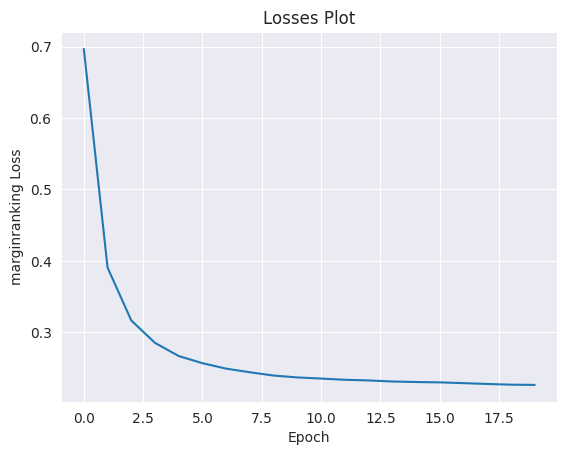

In [9]:
pipeline_result = model_kg.trained_model
pipeline_result.plot_losses()

In [20]:
config = {
        'metadata': dict(
            title='HolE'
        ),
        'pipeline': dict(
            training = 'dataset/ogbl_ddi-my_split/train.txt',
            validation = 'dataset/ogbl_ddi-my_split/valid.txt',
            testing = 'dataset/ogbl_ddi-my_split/test.txt',
            model='HolE',
            model_kwargs=dict(
                   embedding_dim=96,
            ),
            optimizer='SGD',
            optimizer_kwargs=dict(lr=0.09),
            loss='marginranking',
            loss_kwargs=dict(margin=2.64),
            training_loop='slcwa',
            training_kwargs=dict(
                num_epochs=200, 
                batch_size=64, 
                checkpoint_name='HolE_checkpoint-ogb.pt',
                checkpoint_directory='kg_checkpoints',
                checkpoint_frequency=5    
            ),
            negative_sampler='basic',
            negative_sampler_kwargs=dict(num_negs_per_pos=94),
            evaluator='rankbased',
            evaluator_kwargs=dict(filtered=True),
            evaluation_kwargs=dict(batch_size=64),
            stopper='early',
            stopper_kwargs=dict(
                patience=10,
                relative_delta=0.002
            )
        )
    }

In [21]:
pipeline_result = pipeline_from_config(config)

INFO:pykeen.pipeline.api:Running: HolE
INFO:pykeen.pipeline.api:loaded random seed 149710028 from checkpoint.
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /work/.data/pykeen/checkpoints/best-model-weights-67a8eb6f-89d2-43e3-8b8c-b0b85ddda47d.pt
INFO:pykeen.training.training_loop:=> loading checkpoint 'kg_checkpoints/HolE_checkpoint-ogb.pt'
INFO:pykeen.training.training_loop:=> loaded checkpoint 'kg_checkpoints/HolE_checkpoint-ogb.pt' stopped after having finished epoch 200
INFO:pykeen.stoppers.stopper:=> loading stopper summary dict from training loop checkpoint in 'kg_checkpoints/HolE_checkpoint-ogb.pt'
INFO:pykeen.stoppers.stopper:=> loaded stopper summary dictionary from checkpoint in 'kg_checkpoints/HolE_checkpoint-ogb.pt'
Training epochs on cuda:0: 100%|██████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<?, ?epoch/s]
Evaluating on cuda:0: 100%|████

<AxesSubplot: title={'center': 'HolE'}, xlabel='Epoch', ylabel='marginranking Loss'>

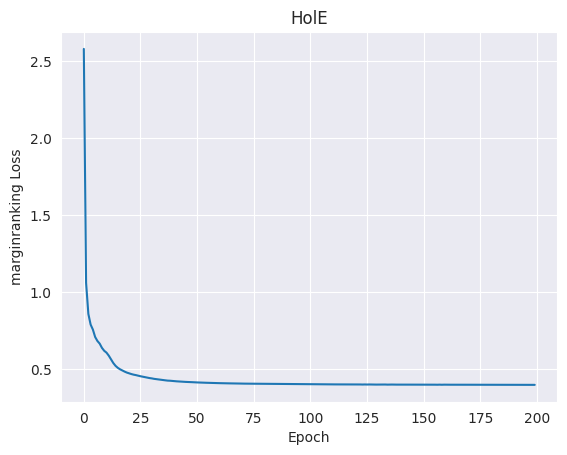

In [22]:
pipeline_result.plot_losses()

### Compute scores for given triplets

In [23]:
# compute scores for positive and negative triplets 
batch_size = 512

n = train.size(0) // batch_size
pos_train_preds = []
for i in range(n+1):
    start_idx = i*batch_size
    end_idx = min((i+1)*batch_size, train.size(0))
    edge = train[start_idx:end_idx]
    pos_train_preds += [pipeline_result.model.score_hrt(edge).squeeze().cpu().detach()]
pos_train_pred = torch.cat(pos_train_preds, dim=0)

n = valid.size(0) // batch_size
pos_valid_preds = []
for i in range(n+1):
    start_idx = i*batch_size
    end_idx = min((i+1)*batch_size, valid.size(0))
    edge = valid[start_idx:end_idx]
    pos_valid_preds += [pipeline_result.model.score_hrt(edge).squeeze().cpu().detach()]
pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

n = valid_neg.size(0) // batch_size
neg_valid_preds = []
for i in range(n+1):
    start_idx = i*batch_size
    end_idx = min((i+1)*batch_size, valid_neg.size(0))
    edge = valid_neg[start_idx:end_idx]
    neg_valid_preds += [pipeline_result.model.score_hrt(edge).squeeze().cpu().detach()]
neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

n = test.size(0) // batch_size
pos_test_preds = []
for i in range(n+1):
    start_idx = i*batch_size
    end_idx = min((i+1)*batch_size, test.size(0))
    edge = test[start_idx:end_idx]
    pos_test_preds += [pipeline_result.model.score_hrt(edge).squeeze().cpu().detach()]
pos_test_pred = torch.cat(pos_test_preds, dim=0)

n = test_neg.size(0) // batch_size
neg_test_preds = []
for i in range(n+1):
    start_idx = i*batch_size
    end_idx = min((i+1)*batch_size, test_neg.size(0))
    edge = test_neg[start_idx:end_idx]
    neg_test_preds += [pipeline_result.model.score_hrt(edge).squeeze().cpu().detach()]
neg_test_pred = torch.cat(neg_test_preds, dim=0)

In [24]:
print(f'Score ranges train: {torch.min(pos_train_pred)} - {torch.max(pos_train_pred)}')
print(f'Score ranges valid: {torch.min(pos_valid_pred)} - {torch.max(pos_valid_pred)}')
print(f'Score ranges valid neg: {torch.min(neg_valid_pred)} - {torch.max(neg_valid_pred)}')
print(f'Score ranges test: {torch.min(pos_test_pred)} - {torch.max(pos_test_pred)}')
print(f'Score ranges test neg: {torch.min(neg_test_pred)} - {torch.max(neg_test_pred)}')

Score ranges train: -18.306095123291016 - 17.180797576904297
Score ranges valid: -16.82921028137207 - 16.24738311767578
Score ranges valid neg: -16.66329574584961 - 16.05899429321289
Score ranges test: -17.16330337524414 - 16.095947265625
Score ranges test neg: -17.372848510742188 - 14.262762069702148


### Evaluate my results

In [37]:
# Evaluate the coputed scores - hits@K

evaluator = Evaluator(name = 'ogbl-ddi')

results = {}
for K in [10, 20, 30]:
    evaluator.K = K
    train_hits = evaluator.eval({
        'y_pred_pos': pos_train_pred,
        'y_pred_neg': neg_valid_pred,
    })[f'hits@{K}']
    valid_hits = evaluator.eval({
        'y_pred_pos': pos_valid_pred,
        'y_pred_neg': neg_valid_pred,
    })[f'hits@{K}']
    test_hits = evaluator.eval({
        'y_pred_pos': pos_test_pred,
        'y_pred_neg': neg_test_pred,
    })[f'hits@{K}']
    
    results[f'Hits@{K}'] = (train_hits, valid_hits, test_hits)
    
    
for hits, result in results.items():
    print(hits)
#     print(result)
    train_hits, valid_hits, test_hits = result
    print(f'Train: {100 * train_hits:.2f}%')
    print(f'Valid: {100 * valid_hits:.2f}%')
    print(f'Test: {100 * test_hits:.2f}%')


Hits@10
Train: 0.01%
Valid: 0.01%
Test: 0.01%
Hits@20
Train: 0.02%
Valid: 0.02%
Test: 0.02%
Hits@30
Train: 0.03%
Valid: 0.03%
Test: 0.02%


In [32]:
print(model_kg.trained_model.get_metric('hits@1'))
print(model_kg.trained_model.get_metric('hits@5'))
print(model_kg.trained_model.get_metric('hits@10'))

0.0005993003168800426
0.0036557319329682597
0.007348920135741521


### Example from OGB

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, cached=True))
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x

In [7]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

In [8]:
def train(model, predictor, x, adj_t, split_edge, optimizer, batch_size):

    row, col, _ = adj_t.coo()
    edge_index = torch.stack([col, row], dim=0)

    model.train()
    predictor.train()

    pos_train_edge = split_edge['train']['edge'].to(x.device)

    total_loss = total_examples = 0
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size,
                           shuffle=True):
        optimizer.zero_grad()

        h = model(x, adj_t)
#         print('h:', h)

        edge = pos_train_edge[perm].t()
#         print('Train: edge:', edge)
#         print()
#         print('h[edge[0]]:', h[edge[0]])
#         print()
#         print('h[edge[1]]:', h[edge[1]])
#         print()

        pos_out = predictor(h[edge[0]], h[edge[1]])
        pos_loss = -torch.log(pos_out + 1e-15).mean()
#         print('pos out:', pos_out)

        edge = negative_sampling(edge_index, num_nodes=x.size(0),
                                 num_neg_samples=perm.size(0), method='dense')

        neg_out = predictor(h[edge[0]], h[edge[1]])
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

        loss = pos_loss + neg_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(x, 1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)

        optimizer.step()

        num_examples = pos_out.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    return total_loss / total_examples

In [9]:
@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size):
#     print('test')
    
    model.eval()
    predictor.eval()

    h = model(x, adj_t)

    pos_train_edge = split_edge['eval_train']['edge'].to(x.device)
    pos_valid_edge = split_edge['valid']['edge'].to(x.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(x.device)
    pos_test_edge = split_edge['test']['edge'].to(x.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(x.device)

    pos_train_preds = []
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size):
        edge = pos_train_edge[perm].t()
        pos_train_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_train_pred = torch.cat(pos_train_preds, dim=0)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)
    
#     print('pos_train_pred:', pos_train_pred)
#     print('neg_train_pred:', neg_valid_pred)
#     print()

    results = {}
    for K in [10, 20, 30]:
        evaluator.K = K
        train_hits = evaluator.eval({
            'y_pred_pos': pos_train_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (train_hits, valid_hits, test_hits)

    return results

In [10]:
hidden_channels = 256
num_layers = 2
dropout = 0.5
runs = 4
lr = 0.005
batch_size = 64 * 1024
epochs = 5
log_steps = 1
eval_steps = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

dataset = PygLinkPropPredDataset(name='ogbl-ddi', transform=T.ToSparseTensor())
data = dataset[0]
adj_t = data.adj_t.to(device)

split_edge = dataset.get_edge_split()

# We randomly pick some training samples that we want to evaluate on:
torch.manual_seed(12345)
idx = torch.randperm(split_edge['train']['edge'].size(0))
idx = idx[:split_edge['valid']['edge'].size(0)]
split_edge['eval_train'] = {'edge': split_edge['train']['edge'][idx]}


model = GCN(hidden_channels, hidden_channels,
                hidden_channels, num_layers,
                dropout).to(device)

emb = torch.nn.Embedding(data.adj_t.size(0),
                         hidden_channels).to(device)

print('Embedding:', emb)
print()
predictor = LinkPredictor(hidden_channels, hidden_channels, 1,
                          num_layers, dropout).to(device)

evaluator = Evaluator(name='ogbl-ddi')
# loggers = {
#     'Hits@10': Logger(args.runs, args),
#     'Hits@20': Logger(args.runs, args),
#     'Hits@30': Logger(args.runs, args),
# }

for run in range(runs):
    torch.nn.init.xavier_uniform_(emb.weight)
#     print('Weights:', emb.weight)
#     print()
    model.reset_parameters()
    predictor.reset_parameters()
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(emb.parameters()) +
        list(predictor.parameters()), lr=lr)

    for epoch in range(1, 1 + epochs):
        loss = train(model, predictor, emb.weight, adj_t, split_edge,
                     optimizer, batch_size)

        if epoch % eval_steps == 0:
#             print('Eval')
            results = test(model, predictor, emb.weight, adj_t, split_edge,
                           evaluator, batch_size)
#             for key, result in results.items():
#                 loggers[key].add_result(run, result)

            if epoch % log_steps == 0:
                for key, result in results.items():
                    train_hits, valid_hits, test_hits = result
                    print(key)
                    print(f'Run: {run + 1:02d}, '
                          f'Epoch: {epoch:02d}, '
                          f'Loss: {loss:.4f}, '
                          f'Train: {100 * train_hits:.2f}%, '
                          f'Valid: {100 * valid_hits:.2f}%, '
                          f'Test: {100 * test_hits:.2f}%')
                print('---')

#     for key in loggers.keys():
#         print(key)
#         loggers[key].print_statistics(run)

# for key in loggers.keys():
#     print(key)
#     loggers[key].print_statistics()

Embedding: Embedding(4267, 256)

Hits@10
Run: 01, Epoch: 01, Loss: 1.2934, Train: 0.02%, Valid: 0.01%, Test: 0.01%
Hits@20
Run: 01, Epoch: 01, Loss: 1.2934, Train: 3.89%, Valid: 3.54%, Test: 1.35%
Hits@30
Run: 01, Epoch: 01, Loss: 1.2934, Train: 4.42%, Valid: 4.06%, Test: 2.65%
---
Hits@10
Run: 01, Epoch: 02, Loss: 0.9930, Train: 3.14%, Valid: 2.92%, Test: 5.51%
Hits@20
Run: 01, Epoch: 02, Loss: 0.9930, Train: 4.43%, Valid: 4.12%, Test: 6.71%
Hits@30
Run: 01, Epoch: 02, Loss: 0.9930, Train: 5.15%, Valid: 4.76%, Test: 7.62%
---
Hits@10
Run: 01, Epoch: 03, Loss: 0.8126, Train: 0.23%, Valid: 0.24%, Test: 0.09%
Hits@20
Run: 01, Epoch: 03, Loss: 0.8126, Train: 0.72%, Valid: 0.66%, Test: 0.12%
Hits@30
Run: 01, Epoch: 03, Loss: 0.8126, Train: 1.19%, Valid: 1.10%, Test: 0.20%
---
Hits@10
Run: 01, Epoch: 04, Loss: 0.7223, Train: 2.55%, Valid: 2.32%, Test: 2.93%
Hits@20
Run: 01, Epoch: 04, Loss: 0.7223, Train: 3.64%, Valid: 3.36%, Test: 5.38%
Hits@30
Run: 01, Epoch: 04, Loss: 0.7223, Train: 4.58